In [1]:
%matplotlib inline

import warnings
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import tempfile
from pathlib import Path


# project root dir
root_dir = Path('/local/sieg/projekte/microminer_evaluation')
sys.path.insert(0, str(root_dir.resolve()))

import helper
from helper.constants import one_2_three_dict, three_2_one_dict
import helper.datasets

In [2]:
plots_outdir = Path('/local/sieg/projekte/microminer_evaluation/plots')

In [3]:
df_problematic = pd.read_csv(root_dir / 'data' / 'problematic_single_mutations.tsv', sep='\t', header=0).astype(str)
df_problematic

,pdb_wild,pdb_mutant,wild_chain,wild_aa,seq_num,mutation_aa,reason
0,2LZM,128L,A,A,93,T,both A
1,1POH,1SPH,A,S,46,A,to D not A
2,2LZM,1L68,A,N,68,A,both N
3,1LZ1,1GAY,A,V,74,G,both V
4,1LZ1,1GAZ,A,V,74,I,both V
...,...,...,...,...,...,...,...
184,1CNQ,1YXI,A,A,54,L,PPI. Chain C missing in 1YXI
185,2TDM,1TSY,A,R,179,K,PPI. Chain B missing in 1TSY
186,2TDM,1TSV,A,R,179,A,PPI. Chain B missing in 1TSV
187,1AMK,1QDS,A,E,65,Q,PPI. Chain B missing in 1QDS


In [4]:
# all the relevant columns microminer writes into its TSV 
microminer_cols = ['queryName', 'queryAA', 'queryChain', 'queryPos',
       'hitName', 'hitAA', 'hitChain', 'hitPos', 'siteIdentity',
       'siteBackBoneRMSD',
#                    'querySiteGaps', 'hitSiteGaps',
#        'siteMismatches',
                   'nofSiteResidues', 'alignmentLDDT', 'fullSeqId']

# Analyse mutant structures annotation of mutation data sets

In [5]:
sns.set()

In [6]:
pal = sns.color_palette('colorblind').as_hex()
pal

['#0173b2',
 '#de8f05',
 '#029e73',
 '#d55e00',
 '#cc78bc',
 '#ca9161',
 '#fbafe4',
 '#949494',
 '#ece133',
 '#56b4e9']

In [7]:
df_anno_counts = pd.read_csv(root_dir / 'annotation_statistics.txt', sep='\t', header=0)
df_anno_counts

,dataset,original_muts_mutants,corrected_muts_mutants,mm_muts_mutants,all_muts_wild_pdb
0,protherm,323,268,749,4142
1,thermomutdb,427,262,970,8010
2,platinum,137,122,237,738
3,prothermdb,0,0,896,6990
4,skempi2,0,0,269,4337
5,fireprotdb,0,0,610,11829


In [8]:
perc_dataset_muts_corrected = df_anno_counts['corrected_muts_mutants'] / df_anno_counts['all_muts_wild_pdb'] * 100
perc_dataset_muts = df_anno_counts['original_muts_mutants'] / df_anno_counts['all_muts_wild_pdb'] * 100
perc_microminer_muts = df_anno_counts['mm_muts_mutants'] / df_anno_counts['all_muts_wild_pdb'] * 100
perc_dataset_muts_corrected.mean(), perc_dataset_muts.mean(), perc_microminer_muts.mean()

(4.378730145553544, 5.282114538150502, 14.414051570883252)

In [9]:
mean_perc_increase_mm_original = (perc_microminer_muts - perc_dataset_muts).mean()
mean_perc_increase_mm_corrected = (perc_microminer_muts - perc_dataset_muts_corrected).mean()
mean_perc_increase_mm_original, mean_perc_increase_mm_corrected

(9.131937032732752, 10.03532142532971)

In [10]:
perc_microminer_muts / perc_dataset_muts_corrected

0    2.794776
1    3.702290
2    1.942623
3         inf
4         inf
5         inf
dtype: float64

In [11]:
df_anno_counts_melted = df_anno_counts.melt('dataset', value_name='counts')
df_anno_counts_melted

,dataset,variable,counts
0,protherm,original_muts_mutants,323
1,thermomutdb,original_muts_mutants,427
2,platinum,original_muts_mutants,137
3,prothermdb,original_muts_mutants,0
4,skempi2,original_muts_mutants,0
5,fireprotdb,original_muts_mutants,0
6,protherm,corrected_muts_mutants,268
7,thermomutdb,corrected_muts_mutants,262
8,platinum,corrected_muts_mutants,122
9,prothermdb,corrected_muts_mutants,0


In [12]:
pal

['#0173b2',
 '#de8f05',
 '#029e73',
 '#d55e00',
 '#cc78bc',
 '#ca9161',
 '#fbafe4',
 '#949494',
 '#ece133',
 '#56b4e9']

In [13]:
# add a new column that contains the percentage of mutations annotated with a structure for the mutant
df_anno_counts_melted['perc'] = np.nan

for d in ['protherm', 'thermomutdb', 'platinum', 'prothermdb', 'fireprotdb', 'skempi2']:

    norm_vals = df_anno_counts_melted.query('dataset == @d and variable == "all_muts_wild_pdb"')['counts'].values
    
    assert len(norm_vals) == 1
    norm_val = norm_vals[0]

    for v in ['original_muts_mutants', 'corrected_muts_mutants', 'mm_muts_mutants']:
        count_vals = df_anno_counts_melted.query('dataset == @d and variable == @v')['counts'].values
        assert len(count_vals) == 1
        count_val = count_vals[0]
        
        perc_val = count_val / norm_val
#         print(perc_val)
        df_anno_counts_melted.loc[(df_anno_counts_melted['dataset'] == d) 
                              &  (df_anno_counts_melted['variable'] == v), 'perc'] = perc_val

df_anno_counts_melted

,dataset,variable,counts,perc
0,protherm,original_muts_mutants,323,0.077982
1,thermomutdb,original_muts_mutants,427,0.053308
2,platinum,original_muts_mutants,137,0.185637
3,prothermdb,original_muts_mutants,0,0.000000
4,skempi2,original_muts_mutants,0,0.000000
5,fireprotdb,original_muts_mutants,0,0.000000
6,protherm,corrected_muts_mutants,268,0.064703
7,thermomutdb,corrected_muts_mutants,262,0.032709
8,platinum,corrected_muts_mutants,122,0.165312
9,prothermdb,corrected_muts_mutants,0,0.000000


In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12), sharey=False, sharex=False,  dpi=600)
plus = 10
subplot_title_size = 25 + plus
tick_size = 15+ plus
x_label_size = 20+ plus
y_label_size = 20+ plus
legend_font_size = 22 + plus


dataset_order = ['protherm', 'thermomutdb', 'platinum', 'prothermdb', 'fireprotdb', 'skempi2']
color_dict = {'all_muts_wild_pdb': pal[8], 'mm_muts_mutants': pal[0], 'original_muts_mutants': pal[3], 'corrected_muts_mutants': pal[4]}
hue_order = ['all_muts_wild_pdb', 'original_muts_mutants', 'corrected_muts_mutants', 'mm_muts_mutants', ]

ax = sns.barplot(data=df_anno_counts_melted, x='dataset', y='counts', hue='variable', order=dataset_order, hue_order=hue_order,
                 ci=None, palette=color_dict)
ax.set_yscale("log")

ax.set_ylabel('log # mutations with wild-type structure', fontsize=y_label_size)
ax.set_xlabel('Mutation Datasets', fontsize=x_label_size)
ax.set_xticks(range(len(dataset_order)), ['ProTherm', 'ThermoMutDB', 'Platinum', 'ProThermDB', 'FireProtDB', 'SKEMPI2'])
handles, labels = ax.get_legend_handles_labels()
labels = ['all single mutations', 'with mutant structure (MicroMiner)',
          'with mutant structure (dataset, errors removed)', 'with mutant structure (dataset, original)']
ax.legend(handles, labels, fontsize=legend_font_size, loc="upper left")

a = [p.get_height() for p in ax.patches]
patch = [p for p in ax.patches]
for i, dataset_name in enumerate(dataset_order):
    for j, var_hue in enumerate(hue_order):
#         print(dataset_name, var_hue)
        perc_vals = df_anno_counts_melted.query('dataset == @dataset_name and variable == @var_hue')['perc'].values
#         print(perc_vals)
        assert len(perc_vals) == 1
        percentage = perc_vals[0]
        if np.isnan(percentage):
            percentage = 1.0
        x = patch[(j*len(dataset_order) + i)].get_x() + patch[(j*len(dataset_order) + i)].get_width() / 2 - 0.15
        y = patch[(j*len(dataset_order) + i)].get_y() + patch[(j*len(dataset_order) + i)].get_height() + 0.5
        ax.annotate(f'{percentage*100:.{2}f}%', (x, y), size = 15)

ax.set_title('Annotating single mutations with mutant structures', fontsize=subplot_title_size)

ax.tick_params(labelsize=tick_size)

plt.tight_layout()
plt.savefig(plots_outdir / 'annotation_single_mutations.png', dpi=600)

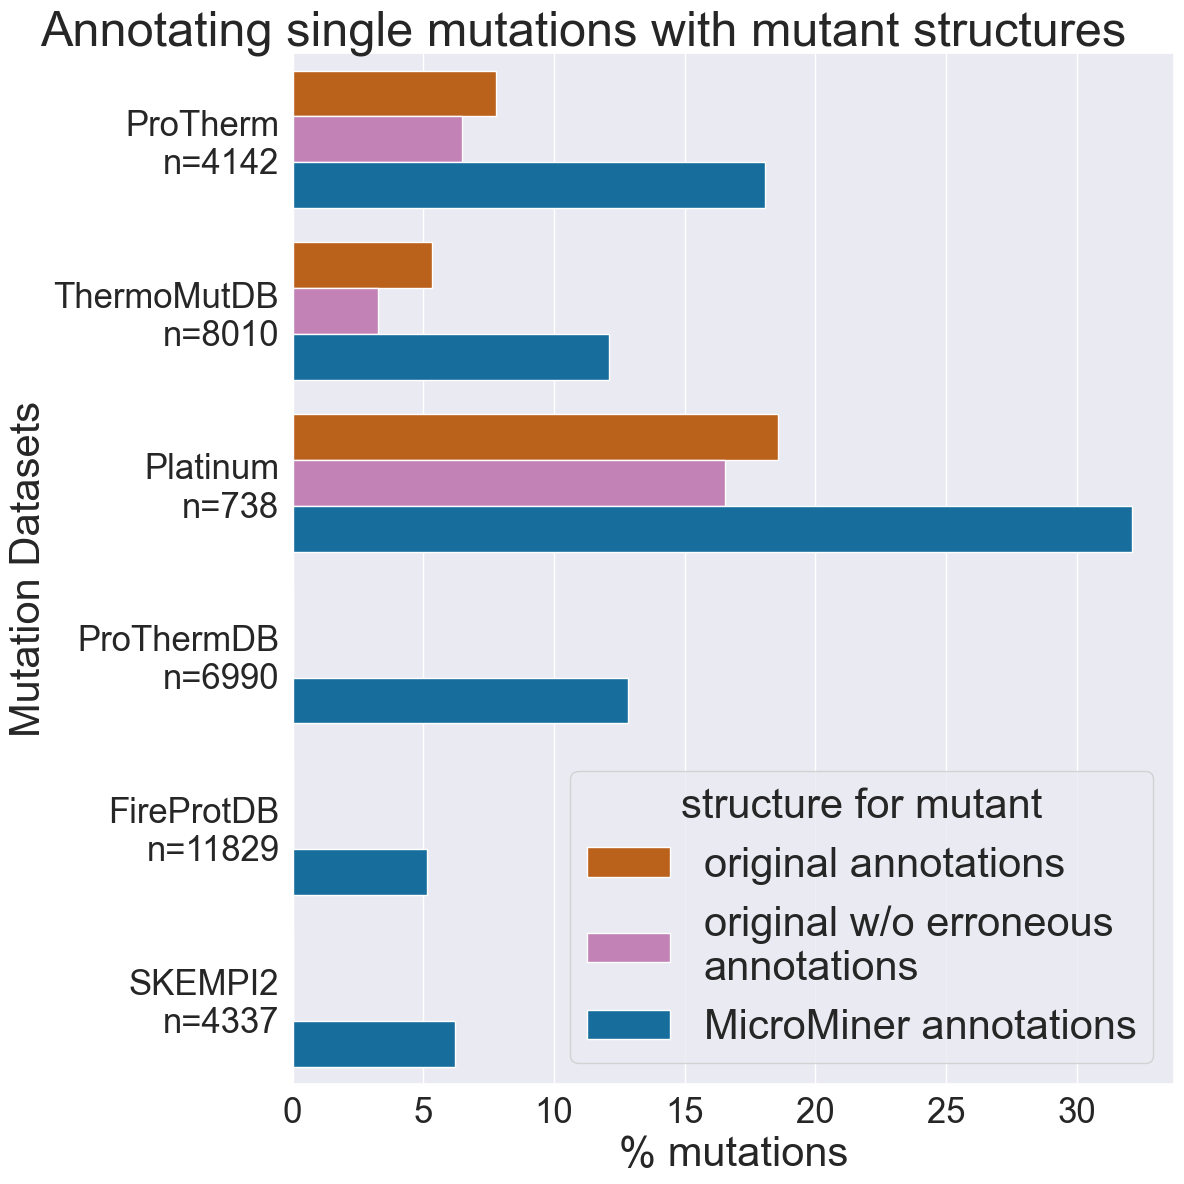

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12), sharey=False, sharex=False)
plus = 10
subplot_title_size = 25 + plus
tick_size = 15+ plus
x_label_size = 20+ plus
y_label_size = 20+ plus
legend_font_size = 22 + plus - 2


dataset_order = ['protherm', 'thermomutdb', 'platinum', 'prothermdb', 'fireprotdb', 'skempi2']
color_dict = {'mm_muts_mutants': pal[0], 'original_muts_mutants': pal[3], 'corrected_muts_mutants': pal[4]}
hue_order = ['original_muts_mutants', 'corrected_muts_mutants', 'mm_muts_mutants', ]

df_anno_counts_melted['perc_100'] = df_anno_counts_melted['perc'] * 100

ax = sns.barplot(data=df_anno_counts_melted, y='dataset', x='perc_100', hue='variable', order=dataset_order, hue_order=hue_order,
                 ci=None, palette=color_dict, orient='h')

ax.set_xlabel('% mutations', fontsize=y_label_size)
ax.set_ylabel('Mutation Datasets', fontsize=x_label_size)

ns = {d[0]: _df['counts'].values[0] for d, _df in df_anno_counts_melted.query('variable == "all_muts_wild_pdb"').groupby(['dataset'])}

ax.set_yticks(range(len(dataset_order)), 
              [f'ProTherm\nn={ns["protherm"]}',
               f'ThermoMutDB\nn={ns["thermomutdb"]}',
               f'Platinum\nn={ns["platinum"]}', 
               f'ProThermDB\nn={ns["prothermdb"]}',
               f'FireProtDB\nn={ns["fireprotdb"]}',
               f'SKEMPI2\nn={ns["skempi2"]}'])
handles, labels = ax.get_legend_handles_labels()
labels = ['original annotations', 'original w/o erroneous\nannotations', 'MicroMiner annotations',]
ax.legend(handles, labels, fontsize=legend_font_size, loc="lower right", title='structure for mutant',
          title_fontsize=legend_font_size)

ax.set_title('Annotating single mutations with mutant structures', fontsize=subplot_title_size, x=0.33)

ax.tick_params(labelsize=tick_size)

plt.tight_layout()
plt.savefig(plots_outdir / 'annotation_single_mutations_horizontal.png', dpi=600)

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(16, 16), sharey=False, sharex=False,  dpi=600)
plus = 10
subplot_title_size = 25 + plus
tick_size = 15+ plus
x_label_size = 20+ plus
y_label_size = 20+ plus
legend_font_size = 22 + plus


dataset_order = ['protherm', 'thermomutdb', 'platinum', 'prothermdb', 'fireprotdb', 'skempi2']
color_dict = {'all_muts_wild_pdb': pal[8], 'mm_muts_mutants': pal[0], 'original_muts_mutants': pal[3], 'corrected_muts_mutants': pal[4]}
hue_order = ['all_muts_wild_pdb', 'mm_muts_mutants', 'corrected_muts_mutants', 'original_muts_mutants']

ax = sns.barplot(data=df_anno_counts_melted.dropna(), x='dataset', y='perc', hue='variable', order=dataset_order, hue_order=hue_order,
                 ci=None, palette=color_dict)

ax.set_ylabel('% mutations with wild-type structure', fontsize=y_label_size)
ax.set_xlabel('Mutation Datasets', fontsize=x_label_size)
ax.set_xticks(range(len(dataset_order)), ['ProTherm', 'ThermoMutDB', 'Platinum', 'ProThermDB', 'FireProtDB', 'SKEMPI2'])
handles, labels = ax.get_legend_handles_labels()
labels = [
#     'all single mutations',
    'with mutant structure (MicroMiner)',
          'with mutant structure (dataset, errors removed)', 'with mutant structure (dataset, original)']
ax.legend(handles, labels, fontsize=legend_font_size, loc="upper left")


ax.set_title('Annotating single mutations with mutant structures', fontsize=subplot_title_size)

ax.tick_params(labelsize=tick_size)

plt.tight_layout()
plt.savefig(plots_outdir / 'annotation_single_mutations.png', dpi=600)

## How many unique mutation pairs (structure for both) are there?

In [17]:
dataset_collection = helper.get_dataset_collection()
datasets = [d.name for d in dataset_collection.get_mutation_datasets_with_structure_pairs()]
datasets = [d for d in datasets if d != 'shanthirabalan']
datasets

['protherm', 'platinum', 'thermomutdb']

In [18]:
# columns needed to merge tables by mutations
key_mut = [helper.WILD_COL, helper.MUTANT_COL, helper.WILD_AA, helper.MUT_AA, helper.WILD_SEQ_NUM]
key_problematic = ['pdb_wild', 'pdb_mutant', 'wild_aa', 'mutation_aa', 'seq_num']

In [19]:
use_dataset = ['protherm', 'thermomutdb', 'platinum', 'prothermdb', 'fireprotdb', 'skempi2']
helper_cols =  [helper.WILD_COL, helper.WILD_AA, helper.MUT_AA, helper.WILD_SEQ_NUM]
use_cols = microminer_cols + helper_cols + [helper.WILD_CHAIN]
use_cols_set = set(use_cols)

df_anno_all_list = []
for d in use_dataset:
    df_d = pd.read_csv(root_dir / f'{d}_annotated.tsv', sep='\t', header=0, usecols=lambda x: x in use_cols_set,
                       low_memory=False)
    df_d = df_d[~df_d['queryName'].isnull()]  # drop rows with no MM result
    
    if not helper.WILD_CHAIN in df_d:
        df_d[helper.WILD_CHAIN] = np.nan
    
    df_d['dataset'] = d
    
    df_anno_all_list.append(df_d[microminer_cols + helper_cols + [helper.WILD_CHAIN, 'dataset']])
    
df_anno_all = pd.concat(df_anno_all_list, ignore_index=True)
df_anno_all

,queryName,queryAA,queryChain,queryPos,hitName,hitAA,hitChain,hitPos,siteIdentity,siteBackBoneRMSD,nofSiteResidues,alignmentLDDT,fullSeqId,wild_pdb,wild_aa,mut_aa,wild_seq_num,wild_chain,dataset
0,1BP2,HIS,A,48.0,2ZP4,ASN,A,48,0.950,0.168,20.0,1.000,0.992,1BP2,HIS,ASN,48,NaN,protherm
1,1BP2,HIS,A,48.0,1KVW,GLN,A,48,0.950,0.239,20.0,0.996,0.992,1BP2,HIS,GLN,48,NaN,protherm
2,2RN2,LYS,A,95.0,1RBT,GLY,A,95,0.875,0.177,8.0,1.000,0.994,2RN2,LYS,GLY,95,NaN,protherm
3,2RN2,LYS,A,95.0,2YV0,GLY,X,95,0.875,0.181,8.0,0.991,0.968,2RN2,LYS,GLY,95,NaN,protherm
4,2RN2,LYS,A,95.0,1RBT,GLY,A,95,0.875,0.177,8.0,1.000,0.994,2RN2,LYS,GLY,95,NaN,protherm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54785,5UFQ,ASP,A,12.0,7OGF,GLY,A,12.0,0.929,0.827,14.0,0.885,0.928,5UFQ,ASP,GLY,12,A,skempi2
54786,5UFQ,ASP,A,12.0,7SCW,GLY,A,12.0,0.929,0.611,14.0,0.942,0.959,5UFQ,ASP,GLY,12,A,skempi2
54787,5UFQ,ASP,A,12.0,7T1F,GLY,A,12.0,0.929,1.376,14.0,0.794,0.970,5UFQ,ASP,GLY,12,A,skempi2
54788,5UFQ,ASP,A,12.0,7VV9,GLY,A,12.0,0.929,0.607,14.0,0.923,0.934,5UFQ,ASP,GLY,12,A,skempi2


In [20]:
print(f'Considering duplicate hits, ${df_anno_all.shape[0]}$ pairs can be used to describe mutations as structure ensembles.')

Considering duplicate hits, $54790$ pairs can be used to describe mutations as structure ensembles.


In [21]:
df_anno_all_u = df_anno_all.drop_duplicates(helper_cols + [helper.WILD_CHAIN])
df_anno_all_u

,queryName,queryAA,queryChain,queryPos,hitName,hitAA,hitChain,hitPos,siteIdentity,siteBackBoneRMSD,nofSiteResidues,alignmentLDDT,fullSeqId,wild_pdb,wild_aa,mut_aa,wild_seq_num,wild_chain,dataset
0,1BP2,HIS,A,48.0,2ZP4,ASN,A,48,0.950,0.168,20.0,1.000,0.992,1BP2,HIS,ASN,48,NaN,protherm
1,1BP2,HIS,A,48.0,1KVW,GLN,A,48,0.950,0.239,20.0,0.996,0.992,1BP2,HIS,GLN,48,NaN,protherm
2,2RN2,LYS,A,95.0,1RBT,GLY,A,95,0.875,0.177,8.0,1.000,0.994,2RN2,LYS,GLY,95,NaN,protherm
6,2RN2,LYS,A,95.0,1RBV,ALA,A,95,0.875,0.126,8.0,1.000,0.994,2RN2,LYS,ALA,95,NaN,protherm
8,2RN2,LYS,A,95.0,1RBU,ASN,A,95,0.875,0.185,8.0,1.000,0.994,2RN2,LYS,ASN,95,NaN,protherm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53520,5UFE,GLY,A,12.0,4L9S,CYS,A,12.0,0.917,1.009,12.0,0.875,0.892,5UFE,GLY,CYS,12,A,skempi2
53652,5UFE,GLY,A,12.0,1HE8,VAL,B,12.0,0.917,0.747,12.0,0.898,0.934,5UFE,GLY,VAL,12,A,skempi2
53738,5UFQ,ASP,A,12.0,121P,GLY,A,12.0,0.929,0.375,14.0,0.984,0.934,5UFQ,ASP,GLY,12,A,skempi2
54250,5UFQ,ASP,A,12.0,4L9W,CYS,A,12.0,0.929,0.615,14.0,0.931,0.934,5UFQ,ASP,CYS,12,A,skempi2


In [22]:
print(f'With the structures retrieved with MicroMiner there are now ${df_anno_all_u.shape[0]}$ unique mutations with wild-type/mutant structure pairs')

With the structures retrieved with MicroMiner there are now $2640$ unique mutations with wild-type/mutant structure pairs


In [23]:
assert df_anno_all_u['queryName'].isnull().sum() == 0  # no nan MM results in this table

In [24]:
len(df_anno_all_u['wild_pdb'].unique())

515

<Axes: >

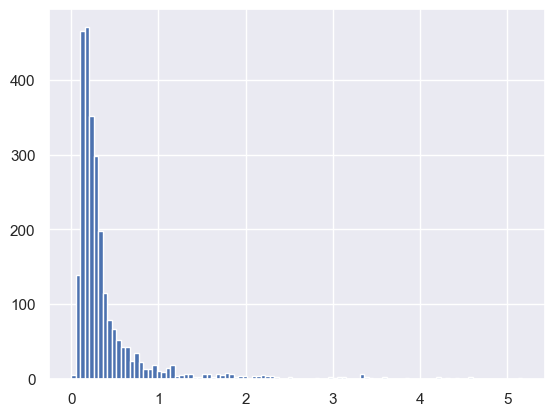

In [25]:
df_anno_all_u['siteBackBoneRMSD'].hist(bins=100)

<Axes: >

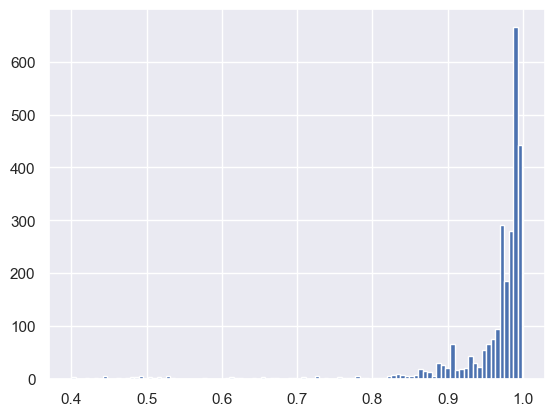

In [26]:
df_anno_all_u['fullSeqId'].hist(bins=100)

In [27]:
df_anno_all_u['queryName'].unique().__len__()

515

In [28]:
# Get number of mutant structure annotated mutation before
helper_cols =  [helper.WILD_COL, helper.WILD_AA, helper.MUT_AA, helper.WILD_SEQ_NUM, helper.MUTANT_COL]
df_anno_b4_list = []
for dataset in datasets:
    print(f'Processing: {dataset}')
    _df = None
    for d in helper.datasets.get_dataset_collection():
        if d.name == dataset:
            _df = d.read_single_mutations(pdb_mutant_only=True)
            break
    if not helper.WILD_CHAIN in _df:
        _df[helper.WILD_CHAIN] = np.nan
    _df['dataset'] = dataset
    df_anno_b4_list.append(_df[helper_cols + [helper.WILD_CHAIN, 'dataset']])
df_anno_b4 = pd.concat(df_anno_b4_list, ignore_index=True)
df_anno_b4

Processing: protherm
Processing: platinum
Processing: thermomutdb


,wild_pdb,wild_aa,mut_aa,wild_seq_num,mut_pdb,wild_chain,dataset
0,2RN2,K,G,95,1RBT,NaN,protherm
1,2RN2,K,G,95,1RBT,NaN,protherm
2,2RN2,K,A,95,1RBV,NaN,protherm
3,2RN2,K,A,95,1RBV,NaN,protherm
4,2RN2,K,N,95,1RBU,NaN,protherm
...,...,...,...,...,...,...,...
2120,2JIE,N,C,166,2O9P,A,thermomutdb
2121,2JIE,N,A,166,2O9P,A,thermomutdb
2122,2JIE,Y,A,21,2O9P,A,thermomutdb
2123,2JIE,M,A,224,2O9P,A,thermomutdb


In [29]:
df_anno_b4['dataset'].unique()

array(['protherm', 'platinum', 'thermomutdb'], dtype=object)

In [30]:
df_anno_b4_u = df_anno_b4.drop_duplicates(helper_cols)# + [helper.WILD_CHAIN])
df_anno_b4_u

,wild_pdb,wild_aa,mut_aa,wild_seq_num,mut_pdb,wild_chain,dataset
0,2RN2,K,G,95,1RBT,NaN,protherm
2,2RN2,K,A,95,1RBV,NaN,protherm
4,2RN2,K,N,95,1RBU,NaN,protherm
6,1IOB,T,G,9,1HIB,NaN,protherm
7,1BNI,L,A,14,1BRH,NaN,protherm
...,...,...,...,...,...,...,...
2120,2JIE,N,C,166,2O9P,A,thermomutdb
2121,2JIE,N,A,166,2O9P,A,thermomutdb
2122,2JIE,Y,A,21,2O9P,A,thermomutdb
2123,2JIE,M,A,224,2O9P,A,thermomutdb


In [31]:
print(f'${df_anno_b4_u.shape[0]}$ uncorrected')

$596$ uncorrected


In [32]:
df_merged = df_anno_b4_u.merge(df_problematic, left_on=key_mut,
                              right_on=key_problematic,
                              how='left', indicator=True)
df_anno_b4_u_corrected = df_merged[df_merged['_merge'] == 'left_only']
df_anno_b4_u_corrected = df_anno_b4_u_corrected.drop('_merge', axis=1)
df_anno_b4_u_corrected

,wild_pdb,wild_aa,mut_aa,wild_seq_num,mut_pdb,wild_chain_x,dataset,pdb_wild,pdb_mutant,wild_chain_y,seq_num,mutation_aa,reason
0,2RN2,K,G,95,1RBT,NaN,protherm,NaN,NaN,NaN,NaN,NaN,NaN
1,2RN2,K,A,95,1RBV,NaN,protherm,NaN,NaN,NaN,NaN,NaN,NaN
2,2RN2,K,N,95,1RBU,NaN,protherm,NaN,NaN,NaN,NaN,NaN,NaN
3,1IOB,T,G,9,1HIB,NaN,protherm,NaN,NaN,NaN,NaN,NaN,NaN
4,1BNI,L,A,14,1BRH,NaN,protherm,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,5OAQ,Y,H,429,6HIK,A,thermomutdb,NaN,NaN,NaN,NaN,NaN,NaN
537,5O30,T,W,123,6I9U,A,thermomutdb,NaN,NaN,NaN,NaN,NaN,NaN
538,5O30,T,G,123,6I9V,A,thermomutdb,NaN,NaN,NaN,NaN,NaN,NaN
539,5O30,T,G,123,6I9W,A,thermomutdb,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
df_merged2 = df_problematic.merge(df_anno_b4_u, left_on=key_problematic,
                              right_on=key_mut,
                              how='left', indicator=True)
df_merged2[df_merged2['_merge'] == 'left_only']

,pdb_wild,pdb_mutant,wild_chain_x,wild_aa,seq_num,mutation_aa,reason,wild_pdb,mut_aa,wild_seq_num,mut_pdb,wild_chain_y,dataset,_merge
166,2J8C,3DUQ,M,N,5,D,nearby terminus unresolved in 3DUQ,NaN,NaN,NaN,NaN,NaN,NaN,left_only
167,2ILI,4QK1,A,K,170,P,terminal H3 unresolved in 4QK1,NaN,NaN,NaN,NaN,NaN,NaN,left_only
168,2ILI,3RGE,A,W,5,H,"terminal H3,H4 unresolved in 3RGE",NaN,NaN,NaN,NaN,NaN,NaN,left_only
169,1LW9,1LLH,A,T,157,I,"terminal N163,L164 unresolved in 1LLH",NaN,NaN,NaN,NaN,NaN,NaN,left_only
176,2RN5,1KVB,A,D,134,N,different proteins,NaN,NaN,NaN,NaN,NaN,NaN,left_only
177,1R2Y,3GQ8,A,Q,234,R,different proteins,NaN,NaN,NaN,NaN,NaN,NaN,left_only
178,2RN4,1KVB,A,K,95,G,different proteins,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [34]:
diff = df_anno_b4_u.shape[0] - df_anno_b4_u_corrected.shape[0] 
print('diff is ', diff)
assert diff == df_problematic.shape[0] - 7  # we expact 7 problematic mutation either in shantirabalan or strange entries (chain-id='unsigned') in thermomutdb

diff is  182


In [35]:
print(f'In summary, before, all six data sets had ${df_anno_b4_u_corrected.shape[0]}$ unique mutations with wild-type/mutant structure pair annotated')

In summary, before, all six data sets had $414$ unique mutations with wild-type/mutant structure pair annotated


In [36]:
df_anno_b4_u_corrected.drop_duplicates(['wild_pdb', 'wild_aa', 'mut_aa', 'wild_seq_num', 'mut_pdb',])

,wild_pdb,wild_aa,mut_aa,wild_seq_num,mut_pdb,wild_chain_x,dataset,pdb_wild,pdb_mutant,wild_chain_y,seq_num,mutation_aa,reason
0,2RN2,K,G,95,1RBT,NaN,protherm,NaN,NaN,NaN,NaN,NaN,NaN
1,2RN2,K,A,95,1RBV,NaN,protherm,NaN,NaN,NaN,NaN,NaN,NaN
2,2RN2,K,N,95,1RBU,NaN,protherm,NaN,NaN,NaN,NaN,NaN,NaN
3,1IOB,T,G,9,1HIB,NaN,protherm,NaN,NaN,NaN,NaN,NaN,NaN
4,1BNI,L,A,14,1BRH,NaN,protherm,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,5OAQ,Y,H,429,6HIK,A,thermomutdb,NaN,NaN,NaN,NaN,NaN,NaN
537,5O30,T,W,123,6I9U,A,thermomutdb,NaN,NaN,NaN,NaN,NaN,NaN
538,5O30,T,G,123,6I9V,A,thermomutdb,NaN,NaN,NaN,NaN,NaN,NaN
539,5O30,T,G,123,6I9W,A,thermomutdb,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
print(f'a ${df_anno_all_u.shape[0] / df_anno_b4_u_corrected.shape[0]:.1f}$-fold increase')

a $6.4$-fold increase
